# Single Model Uses

This notebook shows some uses of the forced baroptric model with singel model runs. See model_ensemble for uses as it pertains to ensembles of runs

In [1]:
# This directive tells the notebook to add interactive plots in the notebook
%matplotlib notebook

from forced_barotropic_sphere.sphere import Sphere #bm3_barotropic_model packages
from forced_barotropic_sphere.solver import Solver
from forced_barotropic_sphere.forcing import Forcing
import forced_barotropic_sphere.plotting as plotters
import forced_barotropic_sphere.ensemble_methods as ensemble_methods
import matplotlib.path as mpath
import forced_barotropic_sphere.parcel_tracking as tracking

import time
import numpy as np
import random
import xarray as xr

import cartopy as crt             # Map projection stuff
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib as mpl          # Plotting routines
import matplotlib.pyplot as plt    
import matplotlib.animation as manim
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable

from tqdm import tqdm

from IPython.display import display, clear_output, HTML, FileLink  # Some technical stuff, used to display animation

/home/bertossa/miniconda3/envs/jupyter/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
##physical constants
s2d = 1/3600/24    # seconds to days
s2h = 1/3600       # seconds to hours
a = 6371e3         # Radius of the earth in m
g00 = 9.81         # Acceleration due to gravity near the surface of the earth in m/s^2
R = 287.           # Dry gas constant in J/K/kg
d2r = np.pi / 180. # Factor to convert degrees to radians
r2d = 180. / np.pi # Factor to convert radians to degrees


We may simply integrate a single model and plot the resulting output at the final integration step

integrating for 6.9 days with a dt of 0.83 hours
output freq of 5.00 hours


<IPython.core.display.Javascript object>


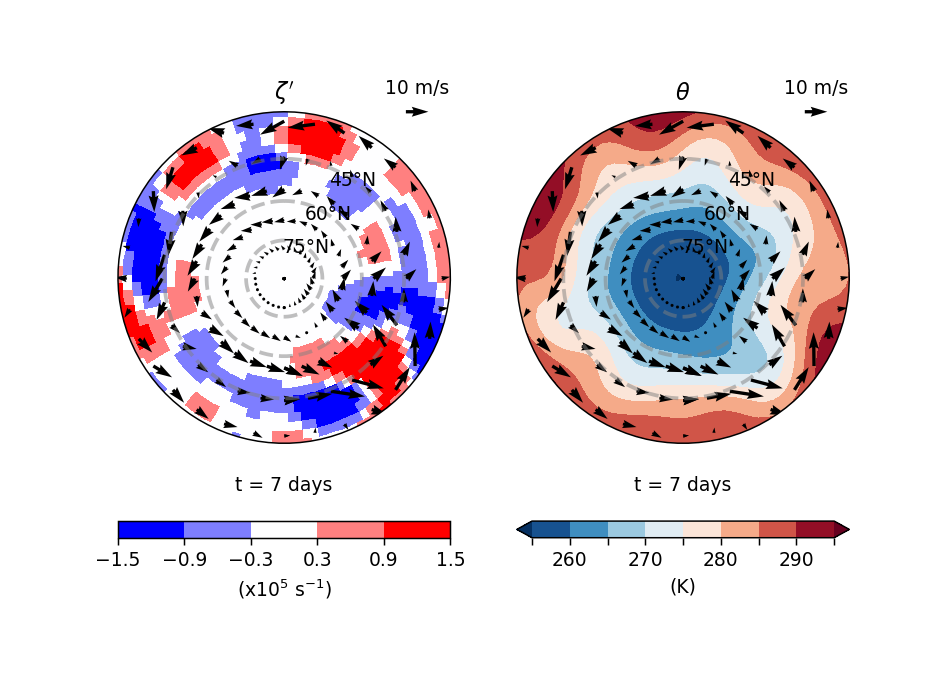

/home/bertossa/miniconda3/envs/jupyter/lib/python3.10/site-packages/cartopy/crs.py:529: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  warnings.warn('Some vectors at source domain corners '


In [3]:
dt = 3000 #time between integration steps (seconds)
Nt = 200 #number of integration steps
T= Nt*dt #total integration time
print('integrating for {:.1f} days with a dt of {:.2f} hours'.format(T*s2d,dt*s2h))

ofreq = 6 #frequency of integration output in resulting ds
print('output freq of {:.2f} hours'.format(dt*s2h*ofreq))

nlat=64; nlon=128 #T42 resolution
#nlat*=2;nlon*=2
st = Sphere(nlat,nlon)
F = Forcing(st,dt,T)
Si = F.generate_rededdy_start() #initial forcing
forcing_tseries = F.generate_rededdy_tseries(A=5e-12,Si=Si) #evolve forcing

k0=6 #if we want to start with some structure in the vorticity here's an option
vortp = 10e-5 * np.exp( -0.5 * (st.glats - 20.)**2 / 10**2 ) * np.cos(k0 * st.rlons)

thetap = np.zeros(vortp.shape) #we'll start with t0=background state
vortp = np.zeros(thetap.shape)
ics = np.array([vortp,thetap])

#choose whether we integrate with a linear temp/vorticity field. temp_linear=False uses nonlinear advection
sln = Solver(st, forcing=F, ofreq=ofreq).integrate_dynamics(temp_linear=True, vort_linear=True)
tidx=int(Nt/ofreq)-1
f,ax = plotters.plot_overview(sln.isel(time=tidx), levels=[np.linspace(-1.5,1.5,6),np.arange(255,300,5)], var=['vortp','theta'])
#f.savefig('./images/L18_singlerun.png',dpi=300, bbox_inches='tight')

In [4]:
#careful..this takes quite a while to run. ~4s/frame
#starttime = time.time()
#plotters.overview_animation(sln, times = [0,T], xs=None)
#print('time taken to animate: ', time.time()-starttime)

MovieWriter ffmpeg unavailable; using Pillow instead.


time taken to animate:  533.8653628826141


### Tracking parcels
We can use a parcel tracking routine to help show spread growth

In [4]:
dsr = sln.rename(dict(x='lon',y='lat'))
# Reassign longitude coordinates between -180 and 180E
dsr = dsr.assign_coords(lon=(((dsr.lon + 180) % 360) - 180))
dsr = dsr.sortby('lon')

x0 = [(-100., l) for l in np.linspace(45, 65, 10)] #initial position of parcel
t0=0. #t0=(0,T)
ts, xs = tracking.calculate_trajectories(dsr, x0, t0 = sln.time.isel(time=0).data)


Integrating 10 trajectories for [6.94444444].
  1. From -100 E, 45 N at 0.0.
  2. From -100 E, 47.2222 N at 0.0.
  3. From -100 E, 49.4444 N at 0.0.
  4. From -100 E, 51.6667 N at 0.0.
  5. From -100 E, 53.8889 N at 0.0.
  6. From -100 E, 56.1111 N at 0.0.
  7. From -100 E, 58.3333 N at 0.0.
  8. From -100 E, 60.5556 N at 0.0.
  9. From -100 E, 62.7778 N at 0.0.
  10. From -100 E, 65 N at 0.0.


100%|█████████████████████████████████████████| 164/164 [00:08<00:00, 18.59it/s]

Completed 165 of 165 timesteps.


In [5]:
#plotters.overview_animation(sln, times = [0,T],filename = 'trajectory.gif', xs=xs,ts=ts)

MovieWriter ffmpeg unavailable; using Pillow instead.
